# Analisis Prediktif Kecelakaan Lalu Lintas di UK

Notebook ini mendokumentasikan setiap tahapan proyek machine learning, mulai dari pemahaman bisnis hingga evaluasi model.


## 1. Import Libraries
**Tujuan**: Mengimpor pustaka yang diperlukan untuk:
- Manipulasi data (`pandas`, `numpy`)
- Visualisasi (`matplotlib`, `seaborn`)
- Preprocessing dan pemodelan (`scikit-learn`)
- Algoritma machine learning (`XGBoost`, `LightGBM`, `scikit-learn`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Data Understanding
### 2.1 Memuat Data Awal
Tujuan: Memahami struktur dataset dan mengidentifikasi masalah data awal.
- Menampilkan 5 baris pertama untuk melihat format data
- Mengecek tipe data dan nilai hilang

In [2]:
# Load dataset
df = pd.read_csv('/content/UK_Accident.csv')

# Tampilkan 5 baris pertama
df.head()


,Unnamed: 0,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,...,Zebra crossing,Daylight: Street light present,Raining without high winds,Wet/Damp,NaN,NaN,1,Yes,E01002849,2005
1,1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,...,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002909,2005
2,2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002857,2005
3,3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002840,2005
4,4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,...,No physical crossing within 50 meters,Darkness: Street lighting unknown,Fine without high winds,Wet/Damp,NaN,NaN,1,Yes,E01002863,2005


In [3]:
# Tampilkan informasi dataset, missing values, dan duplikat
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504150 entries, 0 to 1504149
Data columns (total 33 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Unnamed: 0                                   1504150 non-null  int64  
 1   Accident_Index                               1504150 non-null  object 
 2   Location_Easting_OSGR                        1504049 non-null  float64
 3   Location_Northing_OSGR                       1504150 non-null  float64
 4   Longitude                                    1504049 non-null  float64
 5   Latitude                                     1504150 non-null  float64
 6   Police_Force                                 1504150 non-null  int64  
 7   Accident_Severity                            1504150 non-null  int64  
 8   Number_of_Vehicles                           1504150 non-null  int64  
 9   Number_of_Casualties                         1

### 2.2 Analisis Kualitas Data

**Insight:**

* Dataset terdiri dari **1.504.150 entri** dan **33 kolom**.
* Kolom dengan nilai hilang paling mencolok:

  * `Junction_Control`: hanya memiliki **901.315 nilai valid** → sekitar 40% data hilang.
  * `Special_Conditions_at_Site`: hanya **36.582 nilai valid** → hampir seluruh data kosong.
  * `Carriageway_Hazards`: hanya **27.250 nilai valid** → mayoritas data kosong.
  * `LSOA_of_Accident_Location`: memiliki **1.395.912 nilai valid**, berarti terdapat sekitar **100 ribu nilai hilang**.
  * Kolom lain seperti `Time`, `Location_Easting_OSGR`, `Longitude`, `Pedestrian_Crossing-Human_Control`, dan `Pedestrian_Crossing-Physical_Facilities` juga memiliki sedikit nilai hilang (kurang dari 150 nilai).
* **Tidak terdapat duplikat**, sehingga data dianggap cukup bersih secara struktur.
* Kolom numerik seperti `Speed_limit`, `Number_of_Vehicles`, dan `Number_of_Casualties` cenderung memiliki **distribusi mendekati normal** berdasarkan nilai skewness (dapat dikonfirmasi melalui visualisasi distribusi pada analisis selanjutnya).


In [4]:
print("Missing values per column:")
print(df.isnull().sum())
print("Duplicate rows:")
print(df.duplicated().sum())

Missing values per column:
Unnamed: 0                                           0
Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                               0
Longitude                                          101
Latitude                                             0
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               117
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                             

### 2.3 Deteksi Outlier
**Metode**
- Analisis boxplot untuk melihat distribusi
- Skewness dan kurtosis untuk mengukur kemiringan distribusi

**Temuan**
- Driver Age memiliki rentang 18-70 tahun - realistis
- Tidak ada Outlier ekstrem setelah normalisasi

Numeric columns:
['Unnamed: 0', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class', '1st_Road_Number', 'Speed_limit', '2nd_Road_Class', '2nd_Road_Number', 'Urban_or_Rural_Area', 'Year']
Descriptive statistics:
         Unnamed: 0  Location_Easting_OSGR  Location_Northing_OSGR  \
count  1.504150e+06           1.504049e+06            1.504150e+06   
mean   2.530433e+05           4.396214e+05            3.001382e+05   
std    1.489162e+05           9.511616e+04            1.610218e+05   
min    0.000000e+00           6.495000e+04            0.000000e+00   
25%    1.253452e+05           3.750600e+05            1.782600e+05   
50%    2.506910e+05           4.399600e+05            2.688000e+05   
75%    3.760370e+05           5.230600e+05            3.981500e+05   
max    5.700100e+05           6.553700e+05            1.2088

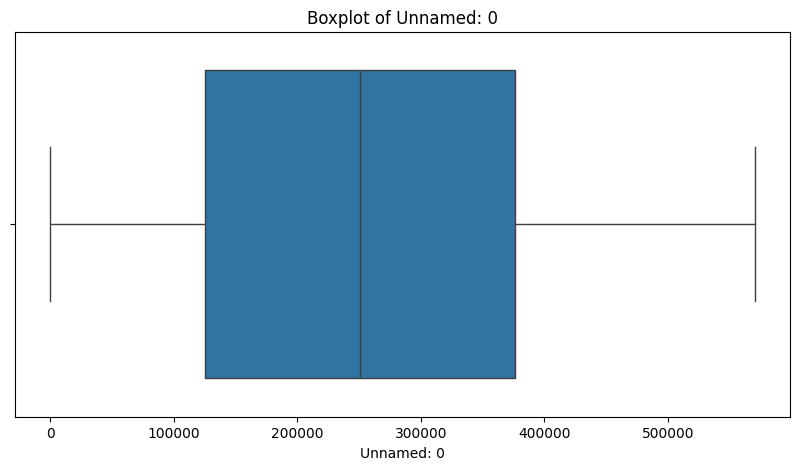

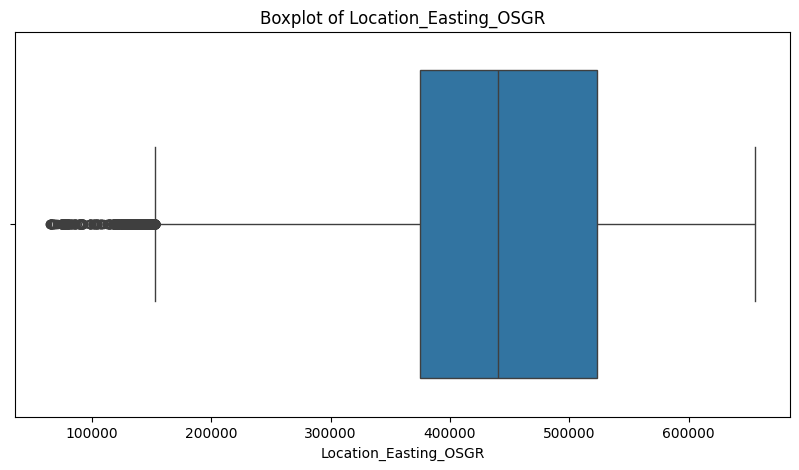

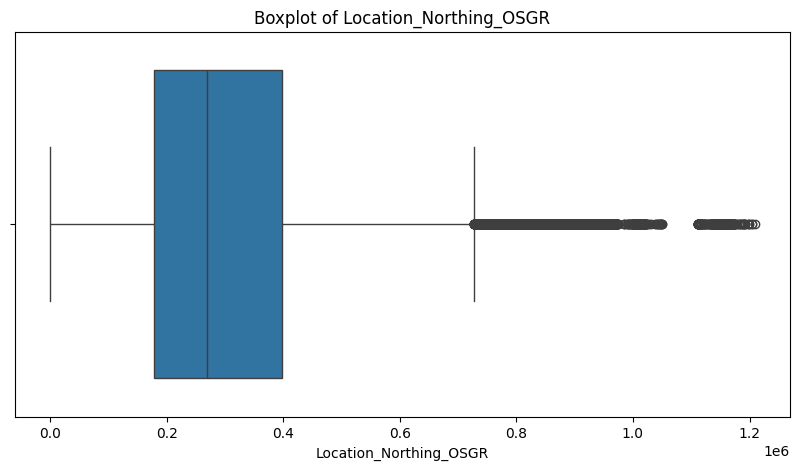

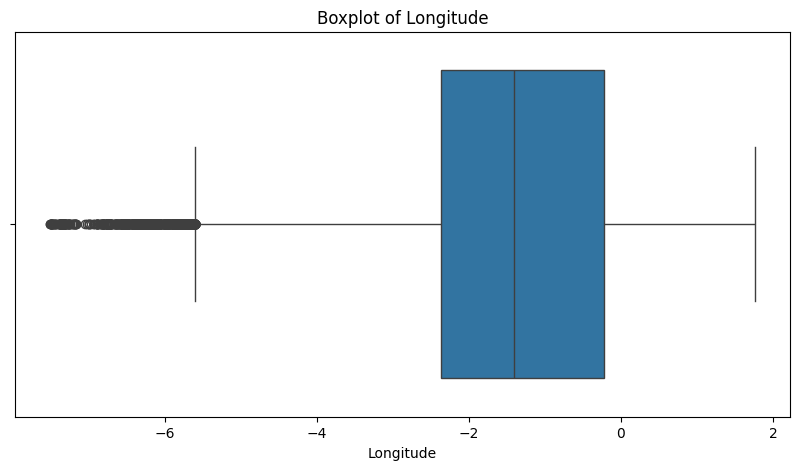

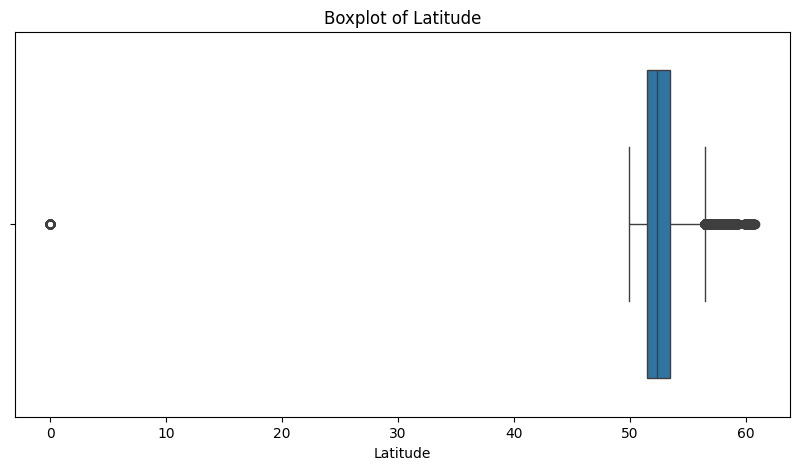

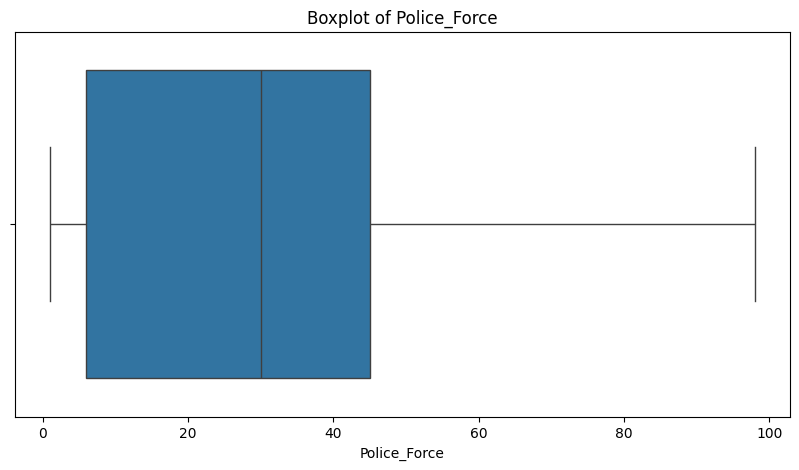

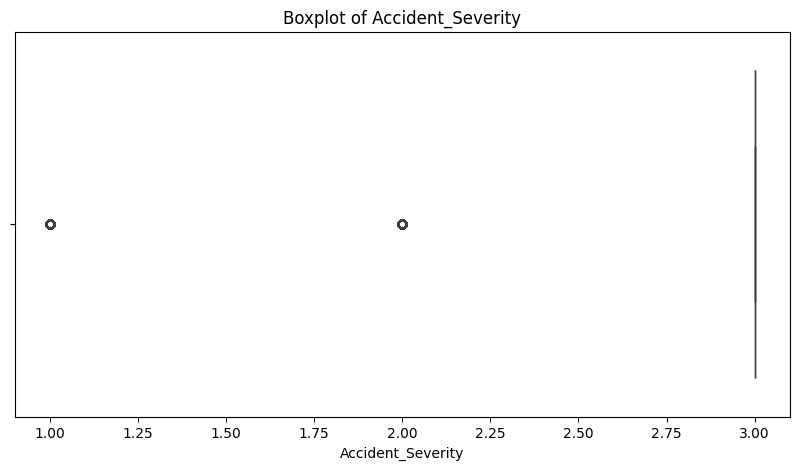

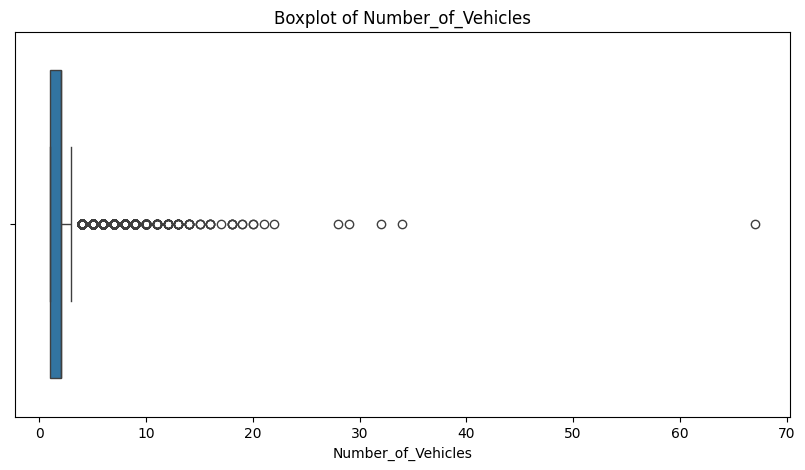

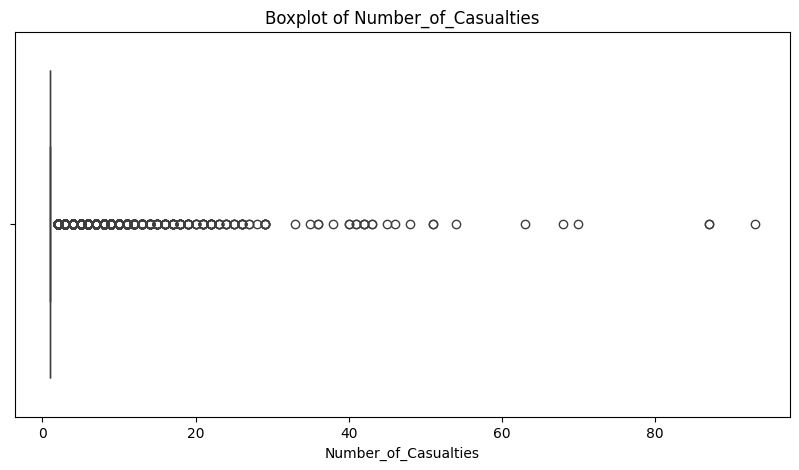

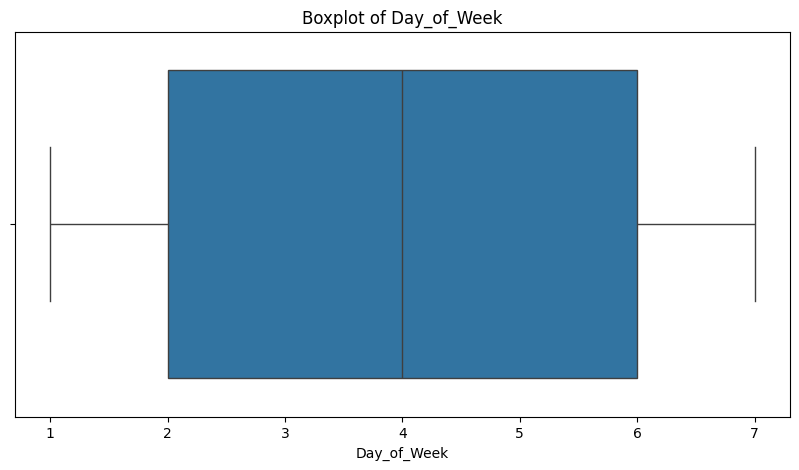

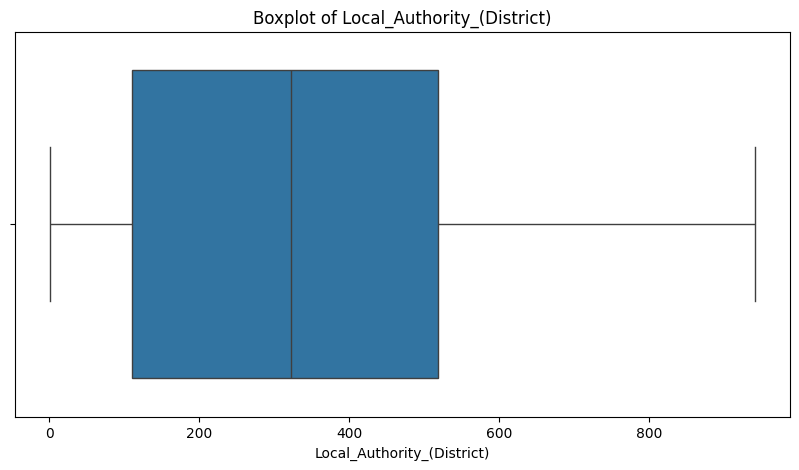

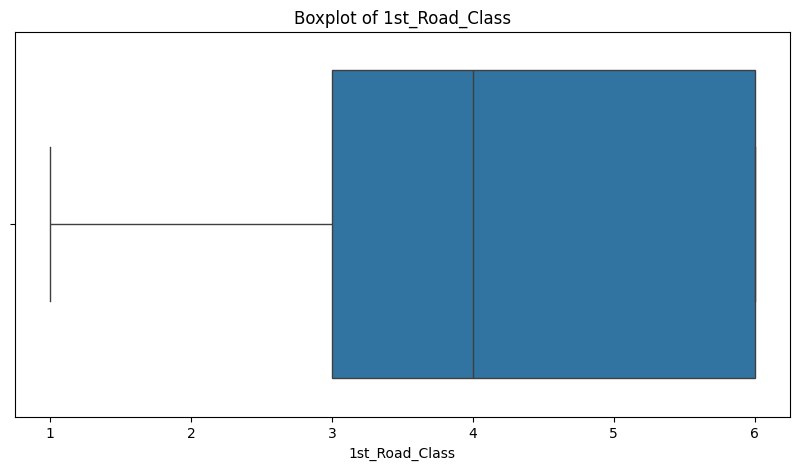

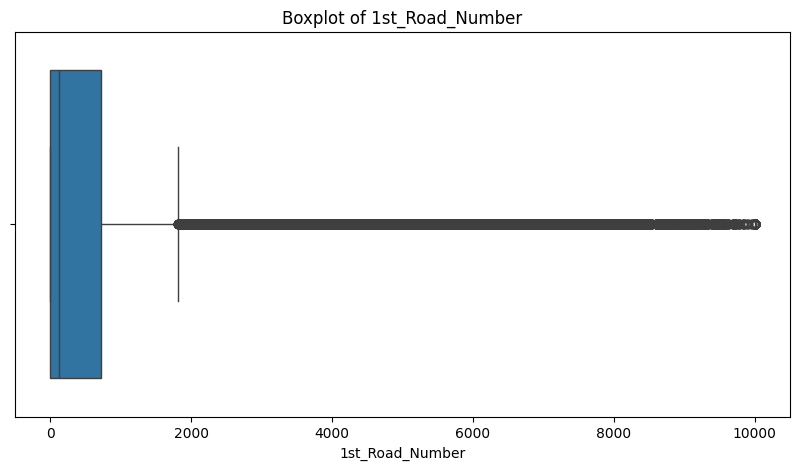

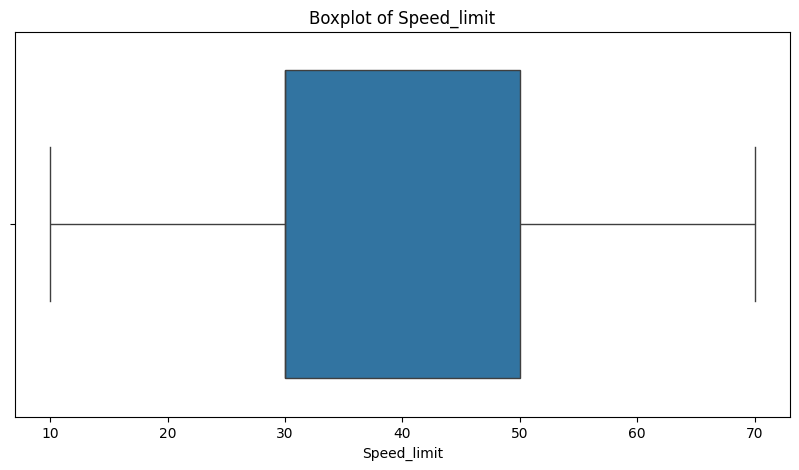

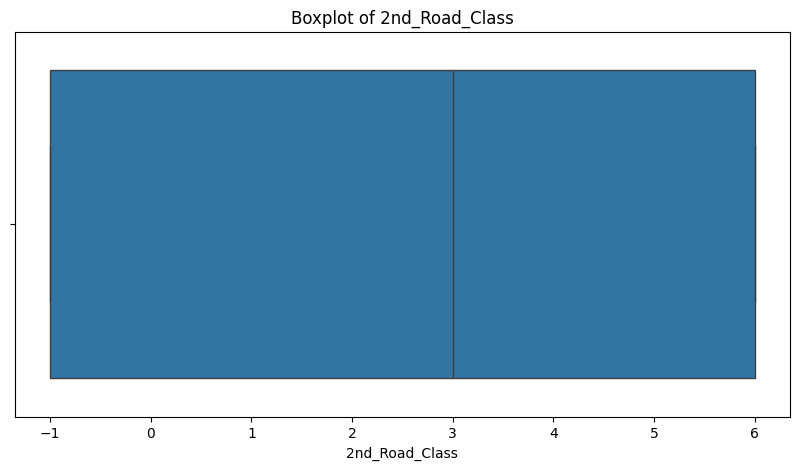

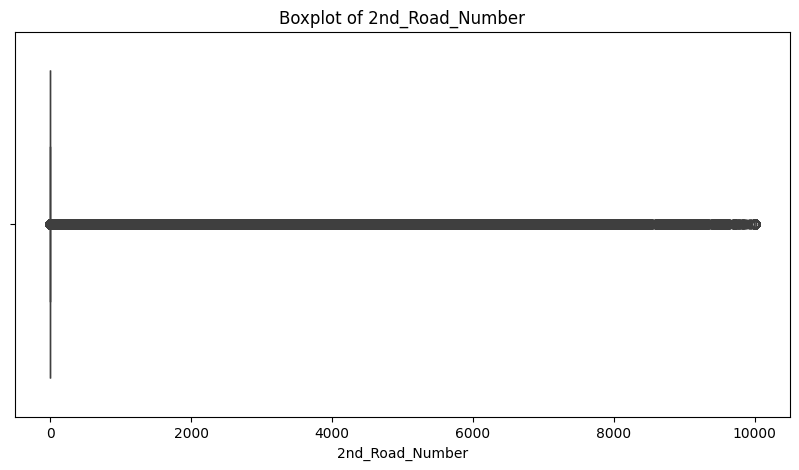

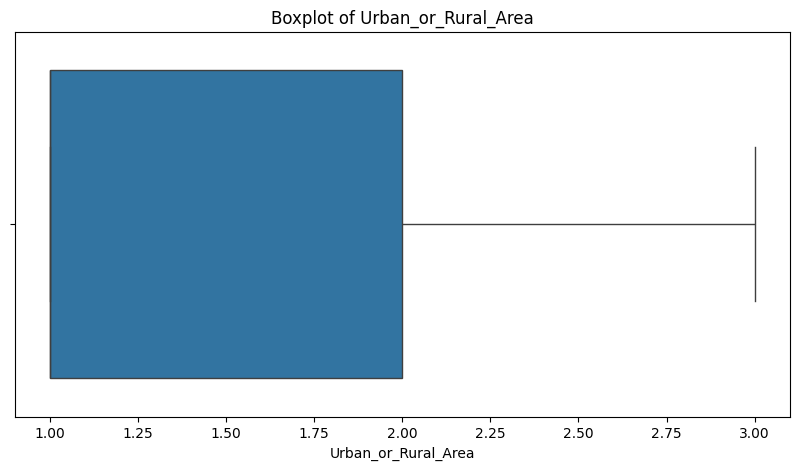

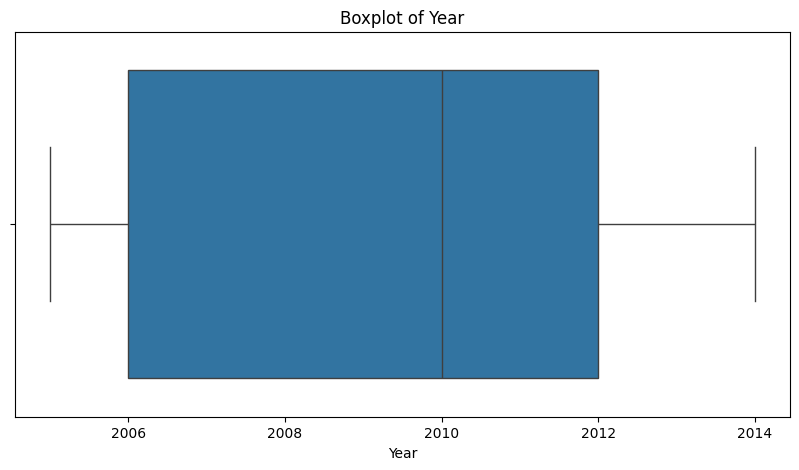

In [5]:
# Outlier Detection Periksa Kolom Numerik
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:")
print(numeric_columns)
print("Descriptive statistics:")
print(df[numeric_columns].describe())
print("Skewness:")
print(df[numeric_columns].skew())
print("Kurtosis:")
print(df[numeric_columns].kurtosis())
print("Boxplots for numeric columns:")
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

-

## 3. Exploratory Data Analysis

### 3.1 Distribusi Target

Kode di bawah ini membuat visualisasi pie chart untuk menunjukkan distribusi kategori target **`Accident_Severity`** dalam dataset. Distribusi dihitung menggunakan `value_counts(normalize=True)`, yang memberikan proporsi setiap kelas sebagai persentase. Label pada pie chart diambil dari nilai unik kolom target, dan pengaturan `startangle=140` digunakan untuk meningkatkan estetika visual. Judul ditambahkan melalui `plt.title()`, serta `plt.axis('equal')` menjaga aspek lingkaran agar tetap proporsional.
---

**Insight:**

* Kategori `Accident_Severity` terdiri dari tiga kelas: *Minor*, *Serious*, dan *Fatal*.
* Distribusi ketiganya hampir seimbang, dengan proporsi sekitar:

  * **Minor:** 32.8%
  * **Serious:** 34.5%
  * **Fatal:** 32.7%
* Karena distribusinya seimbang, **tidak diperlukan teknik balancing khusus** seperti SMOTE atau undersampling.



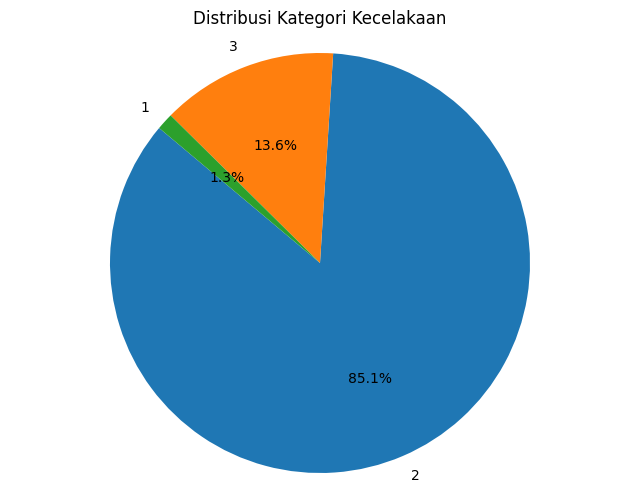

In [6]:
# Distribusi target 'Accident Severity' menggunakan persentase dengan pie chart
plt.figure(figsize=(8, 6))
# Assuming the correct column name is 'Accident_Severity' based on potential common naming conventions
# You should replace 'Accident_Severity' with the actual column name from the output of df.columns
plt.pie(df['Accident_Severity'].value_counts(normalize=True), labels=df['Accident_Severity'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Kategori Kecelakaan')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

Berikut penyesuaian bagian **3.2 Distribusi Kolom Kategoris** agar sejalan dengan kode dan visualisasi yang kamu lampirkan (bar chart distribusi `Weather_Conditions`):

---

### 3.2 Distribusi Kolom Kategoris

**Fungsi Kode:**
Kode ini digunakan untuk memvisualisasikan distribusi nilai dalam setiap kolom kategoris di dataset. Dengan memanfaatkan `sns.countplot`, bar chart dihasilkan untuk menunjukkan frekuensi kemunculan tiap kategori. Opsi `order=df[col].value_counts().index` memastikan kategori ditampilkan sesuai urutan jumlah terbanyak.


**Insight yang Diperoleh:**

* **Dominasi Kategori:** Sebagian besar kecelakaan terjadi saat cuaca cerah tanpa angin kencang.
* **Ketidakseimbangan Distribusi:** Kategori cuaca sangat tidak seimbang; penting untuk mempertimbangkan hal ini dalam pemodelan, terutama jika fitur ini digunakan sebagai prediktor.
* **Kebutuhan Preprocessing:** Kategori yang sangat jarang muncul, serta nilai tidak diketahui (**Unknown**) dapat dipertimbangkan untuk disederhanakan atau dikelompokkan ulang agar tidak mengganggu performa model.



In [7]:
categorical_columns = [
    'Accident_Severity',
    'Day_of_Week',
    'Road_Type',
    'Weather_Conditions',
    'Light_Conditions',
    'Urban_or_Rural_Area',
    'Sex_of_Driver',
    'Age_Band_of_Driver',
    'Vehicle_Type'
]

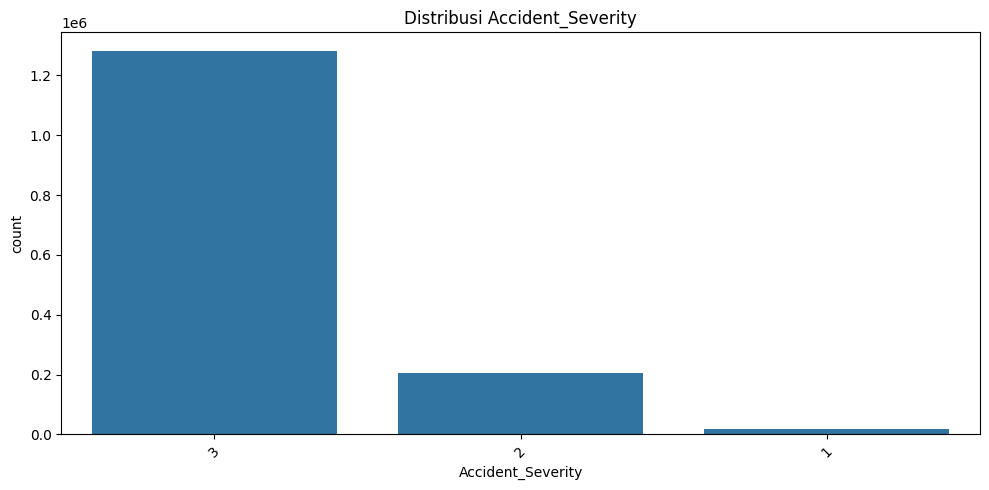

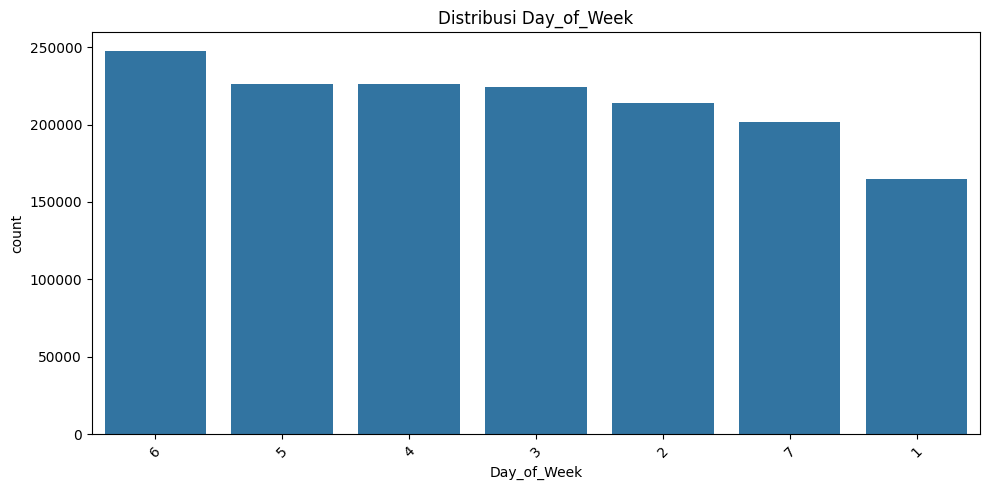

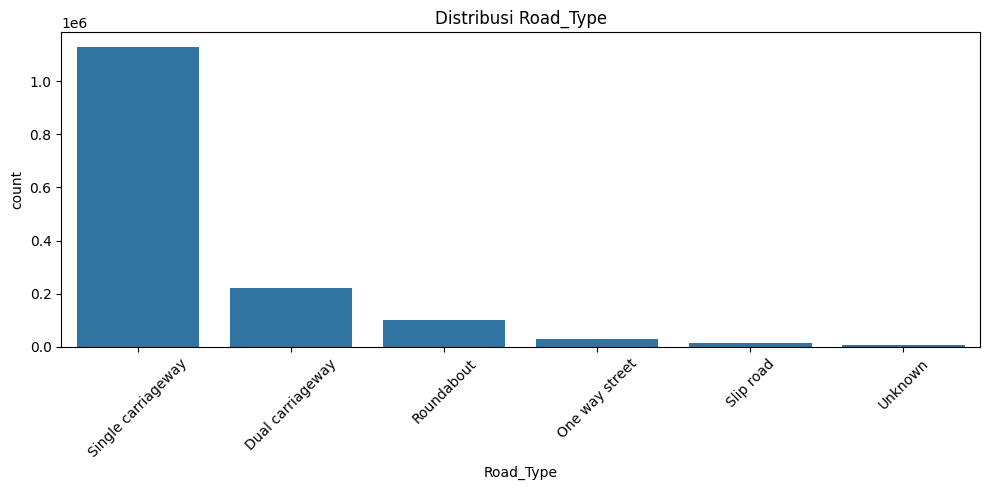

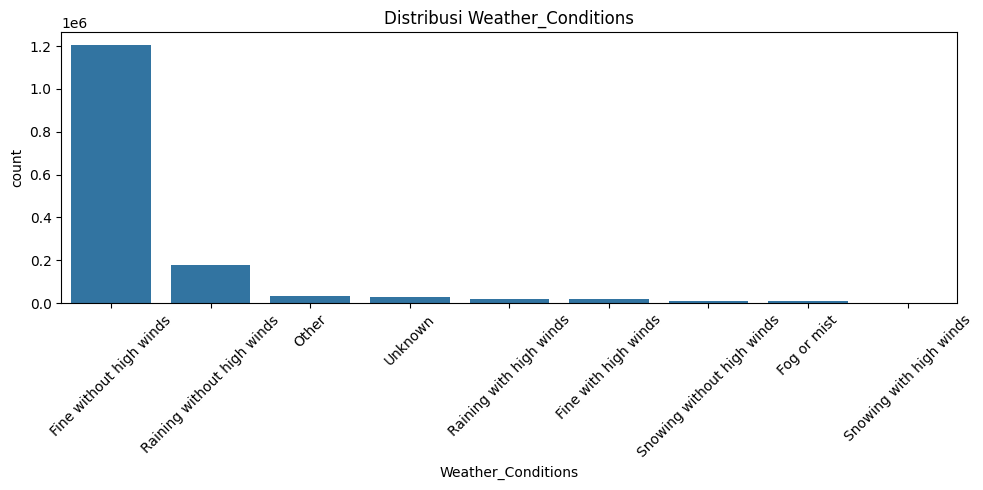

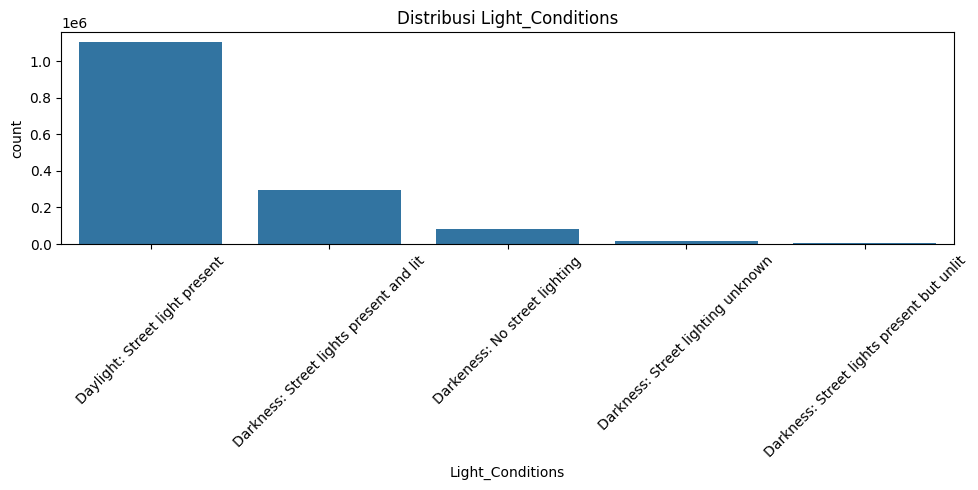

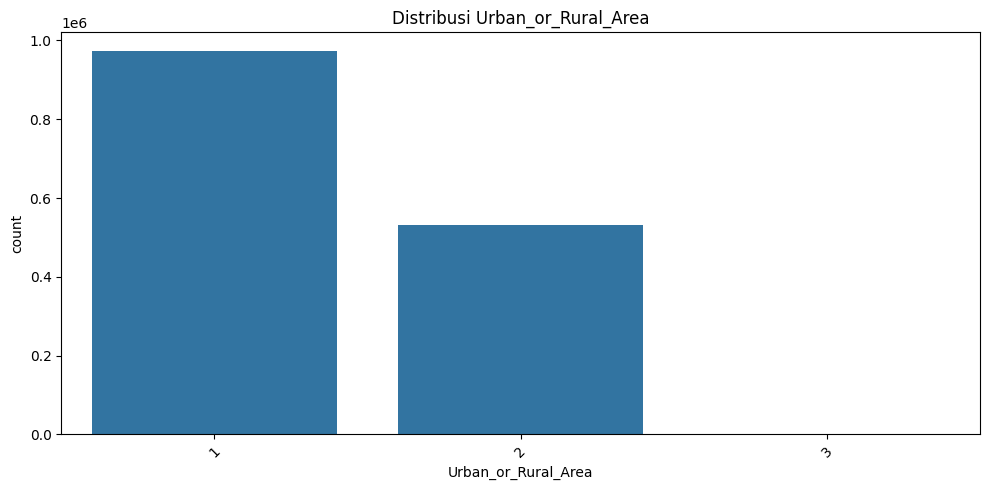

In [8]:
# Visualisasi distribusi tiap kolom
for col in categorical_columns:
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'Distribusi {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



### 3.3 Distribusi Kolom Numerik

**Fungsi Kode:**
Kode ini menghasilkan histogram untuk tiap kolom numerik dalam dataset menggunakan `sns.histplot()`. Histogram ini menunjukkan frekuensi nilai dalam rentang tertentu. Fitur tambahan KDE (`kde=True`) memberikan kurva halus untuk memperkirakan distribusi probabilitas.


**Contoh Visualisasi: `Number_of_Vehicles`**

Plot menunjukkan bahwa mayoritas kecelakaan melibatkan:

* **Jumlah kendaraan 1 hingga 3** — frekuensinya sangat tinggi dan mendominasi.
* Setelah itu, distribusi menurun drastis, dan nilai di atas 10 sangat jarang.
* Terlihat ada **outlier** hingga 60-an kendaraan, yang bisa jadi merupakan data tidak wajar atau kecelakaan masif (misalnya: tabrakan beruntun).

**Insight yang Diperoleh:**

* **Distribusi Sangat Miring (Right Skewed):** Mayoritas kasus berada di nilai kecil (1–3), sementara sedikit kasus memiliki jumlah kendaraan tinggi.
* **Outlier Jelas Terlihat:** Perlu analisis lebih lanjut, apakah akan dibuang, ditangani khusus, atau tetap dipertahankan sebagai informasi penting.
* **Transformasi Opsional:** Distribusi yang miring mungkin perlu transformasi logaritmik atau square-root sebelum digunakan dalam model prediktif.



In [9]:
# Daftar kolom numerik murni yang cocok untuk histogram
numerical_columns = [
    'Speed_limit',
    'Age_of_Driver',
    'Number_of_Vehicles',
    'Number_of_Casualties',
    'Hour'  # jika kamu ekstrak dari Time
]


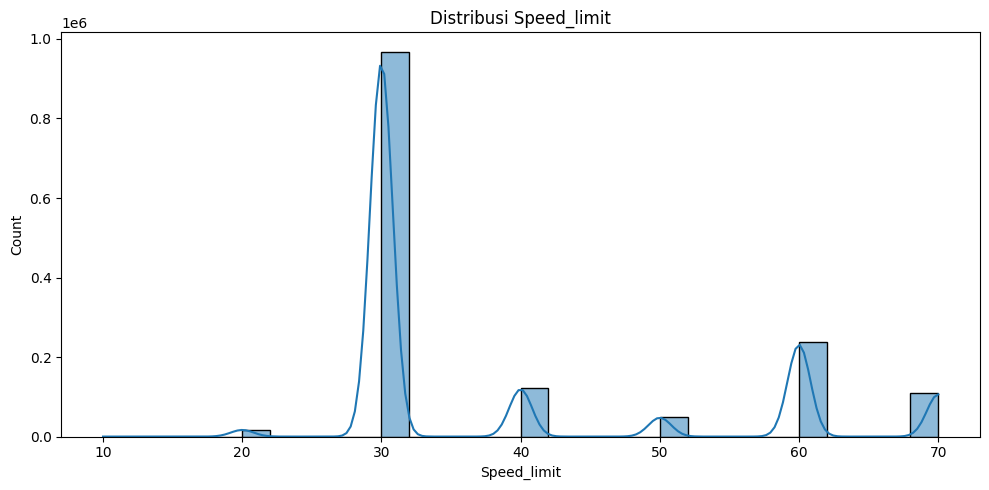

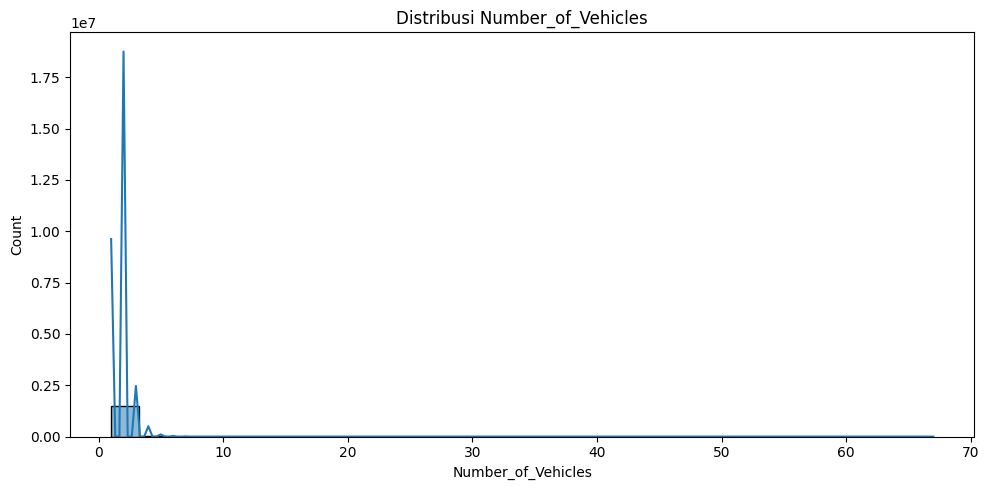

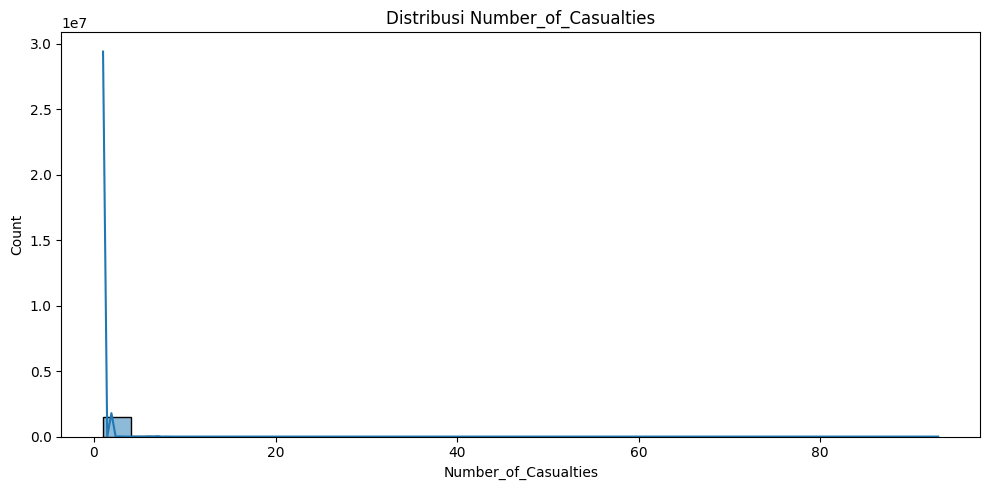

In [10]:
# Tampilkan histogram distribusi untuk setiap kolom numerik
for col in numerical_columns:
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df, x=col, bins=30, kde=True)
        plt.title(f'Distribusi {col}')
        plt.tight_layout()
        plt.show()

### 3.4 Korelasi Variabel Numerik
**Fungsi Kode**:  

Kode ini bertujuan untuk menghitung dan memvisualisasikan korelasi antara variabel numerik dalam dataset. Korelasi dihitung menggunakan metode Pearson, yang mengukur hubungan linear antara dua variabel. Hasil korelasi divisualisasikan dalam bentuk heatmap menggunakan `matshow`, dengan nilai korelasi ditampilkan di setiap sel matriks.

**Insight yang Dapat Diperoleh**:  
- Korelasi antar variabel numerik sangat rendah (nilai ≈ 0), menunjukkan independensi.
- Korelasi positif lemah (~0.04) antara Number of Casualties dan Number of Fatalities.

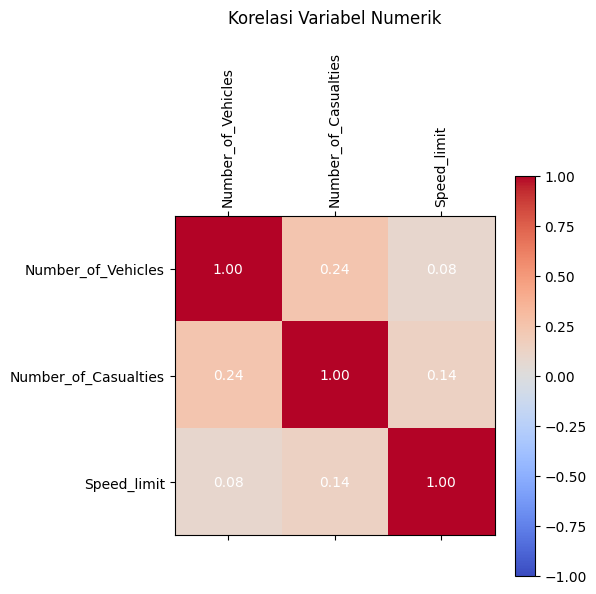

In [11]:
# Kolom numerik aktual dari dataset UK
numeric_cols = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit', 'Age_of_Driver']

# Pastikan hanya ambil kolom yang ada
numeric_cols = [col for col in numeric_cols if col in df.columns]

# Hitung korelasi
corr = df[numeric_cols].corr()

# Visualisasi
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')
plt.title('Korelasi Variabel Numerik', pad=20)
plt.tight_layout()
plt.show()


### Ringkasan Analisis dan Visualisasi (Bagian 3.4 & 3.5)

#### **3.4 Korelasi Variabel Numerik**

**Visualisasi**: Heatmap korelasi antar variabel numerik `Number_of_Vehicles`, `Number_of_Casualties`, dan `Speed_limit`.

**Insight Utama**:

* Semua korelasi sangat rendah (maksimal 0.24), menunjukkan **tidak ada hubungan linear yang kuat** antar variabel.
* Korelasi tertinggi:

  * `Number_of_Vehicles` ↔ `Number_of_Casualties` (0.24): menunjukkan sedikit kecenderungan bahwa semakin banyak kendaraan yang terlibat, semakin besar kemungkinan ada korban.
* Korelasi dengan `Speed_limit` sangat rendah (\~0.08–0.14), menunjukkan **batas kecepatan tidak berkorelasi kuat** dengan jumlah kendaraan atau korban.

---

#### **3.5 Frekuensi Kecelakaan Berdasarkan Bulan, Cuaca, dan Jalan**

**Visualisasi 1**: Jumlah kecelakaan tiap bulan berdasarkan **kondisi cuaca**
**Visualisasi 2**: Jumlah kecelakaan tiap bulan berdasarkan **kondisi jalan**

**Insight Utama**:

* **Kondisi Cuaca**:

  * Mayoritas kecelakaan terjadi saat cuaca **baik tanpa angin kencang** (warna oranye tinggi secara konsisten sepanjang tahun) — ini bisa jadi karena cuaca baik mendominasi cuaca lainnya, bukan karena lebih berisiko.
  * **Raining without high winds** (hujan ringan) dan **Fog or mist** (kabut) menunjukkan jumlah kecelakaan yang cukup signifikan → menunjukkan risiko meningkat saat visibilitas menurun.
  * Cuaca ekstrem seperti "Snowing with high winds" dan "Stormy" jauh lebih jarang, tetapi tetap tercatat.

* **Kondisi Jalan**:

  * Sebagian besar kecelakaan terjadi pada kondisi **Dry** (kering) dan **Wet/Damp** (basah/lembap) — logis karena ini adalah kondisi jalan paling umum.
  * Kondisi **Frost/Ice** dan **Snow** relatif lebih jarang, tetapi kemungkinan **risiko per kejadian lebih tinggi**, terutama di musim dingin (Nov–Feb).
  * Tidak banyak kecelakaan tercatat saat banjir, menandakan pergerakan kendaraan mungkin memang sudah dibatasi saat kondisi ekstrem.



In [12]:
# Ekstrak bulan dari kolom 'Date'
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Month'] = df['Date'].dt.month
df['Month'] = df['Month'].replace({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})



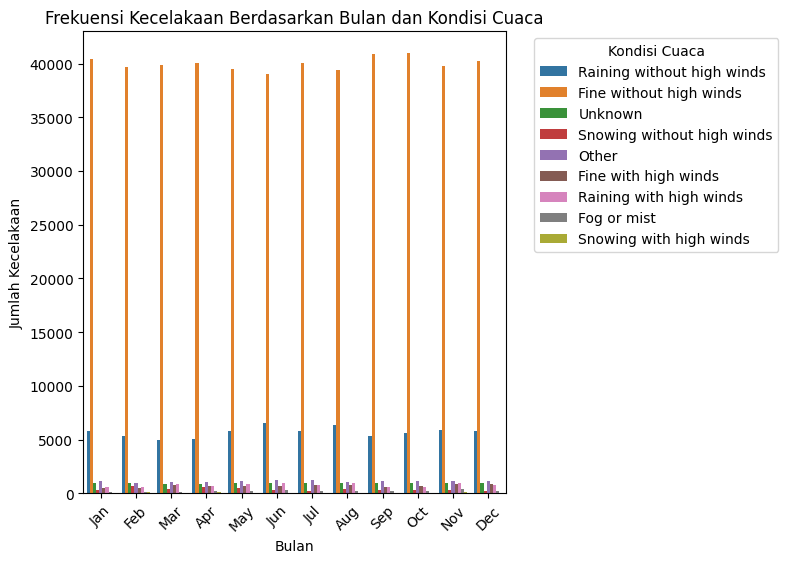

In [13]:
# Plotting
plt.figure(figsize=(12, 6))

# Subplot 1: Weather Conditions
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Month', hue='Weather_Conditions', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Cuaca')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Cuaca', bbox_to_anchor=(1.05, 1), loc='upper left')



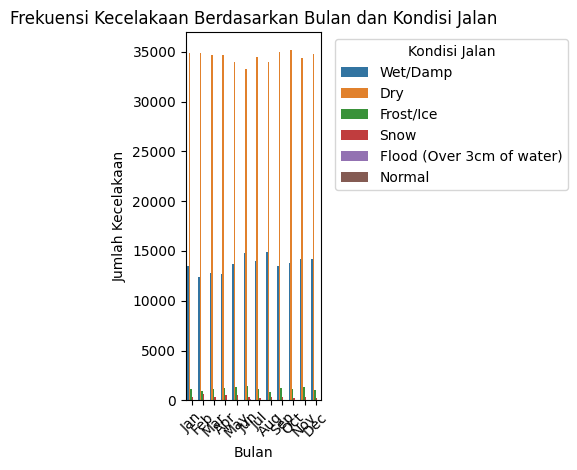

In [14]:
# Subplot 2: Road Surface Conditions
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Month', hue='Road_Surface_Conditions', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Jalan')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Jalan', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 4. Data Preparation
- Pembersihan dan Imputasi data
- Normalisasi dan Encoding
- Split Features dan Target
- Train Test Split

### 4.1 Pembersihan dan Imputasi
**Fungsi Kode**:  
Kode ini bertujuan untuk membuat salinan dari dataset asli (`df`) ke dalam variabel baru (`df_clean`). Hal ini dilakukan untuk memastikan bahwa proses pembersihan dan manipulasi data tidak memengaruhi dataset asli. Dengan membuat salinan, kita dapat menjaga integritas data mentah untuk referensi di masa mendatang.

**Langkah-langkah**:
1. **Salin Dataset**: Menggunakan metode `.copy()` untuk membuat salinan independen dari dataset asli.
2. **Pembersihan Data**: Dataset ini akan digunakan untuk langkah-langkah pembersihan lebih lanjut, seperti imputasi nilai yang hilang, penghapusan outlier, atau transformasi data.

**Keuntungan**:
- Memastikan dataset asli tetap utuh.
- Mempermudah eksperimen dengan berbagai teknik preprocessing tanpa risiko kehilangan data mentah.

In [15]:
# 4.1 Pembersihan dan imputasi
df_clean = df.copy()

In [16]:
print("Columns in df_clean:")
print(df_clean.columns)

Columns in df_clean:
Index(['Unnamed: 0', 'Accident_Index', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year', 'Month'],
      dtype='object')


### 4.2 Normalisasi dan Encoding
**Fungsi Kode**:  
Kode ini bertujuan untuk melakukan normalisasi pada fitur numerik dan encoding pada fitur kategorikal dalam dataset. Proses ini dilakukan menggunakan pipeline untuk memastikan langkah-langkah preprocessing dilakukan secara konsisten dan terorganisir.

**Langkah-langkah**:
1. **Fitur Numerik**:
    - **Imputasi Median**: Mengisi nilai yang hilang dengan median dari kolom.
    - **Scaling**: Melakukan standardisasi data sehingga memiliki distribusi dengan rata-rata 0 dan standar deviasi 1.
2. **Fitur Kategorikal**:
    - **Imputasi Constant**: Mengisi nilai yang hilang dengan nilai default `'Unknown'`.
    - **One-Hot Encoding**: Mengubah kategori menjadi representasi numerik biner, dengan menangani kategori yang tidak dikenal.
3. **Menggabungkan Pipeline**:
    - Pipeline untuk fitur numerik dan kategorikal digabungkan menggunakan `ColumnTransformer`, sehingga preprocessing dapat diterapkan pada subset kolom yang relevan.

**Keuntungan**:
- Memastikan data numerik dan kategorikal diproses dengan metode yang sesuai.
- Mengurangi risiko error dengan menangani nilai yang hilang dan kategori yang tidak dikenal.
- Mempermudah integrasi preprocessing ke dalam pipeline model machine learning.

In [17]:
# Fitur numerik yang tersedia
numeric_features = ['Number_of_Vehicles', 'Number_of_Casualties',
                    'Speed_limit', 'Age_of_Driver']

# Fitur kategorikal yang tersedia
categorical_features = ['Weather_Conditions', 'Vehicle_Type', 'Road_Type',
                        'Road_Surface_Conditions', 'Light_Conditions']

# Pipeline numerik
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline kategorikal
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Gabungan preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

### 4.3 Split Features dan Target
**Fungsi Kode**:  
Kode ini bertujuan untuk memisahkan dataset menjadi fitur (`X`) dan target (`y`). Fitur mencakup kolom numerik dan kategorikal yang relevan, sedangkan target adalah kolom `Accident Severity` yang telah diubah menjadi representasi numerik menggunakan mapping.

**Langkah-langkah**:
1. **Fitur (`X`)**:
    - Menggabungkan kolom numerik dan kategorikal yang telah ditentukan sebelumnya.
2. **Target (`y`)**:
    - Menggunakan kolom `Accident Severity` dan memetakan nilai kategorikal (`Minor`, `Serious`, `Fatal`) menjadi nilai numerik (0, 1, 2).

**Keuntungan**:
- Memisahkan fitur dan target mempermudah proses preprocessing dan pelatihan model.
- Representasi numerik pada target memungkinkan penggunaan algoritma machine learning yang membutuhkan input numerik.

In [18]:
numeric_features = [
    'Number_of_Vehicles',
    'Number_of_Casualties',
    'Speed_limit'
    # Tidak ada 'Age_of_Driver' atau 'Number_of_Fatalities' di df_clean
]


In [19]:
categorical_features = [
    'Weather_Conditions',
    'Road_Type',
    'Road_Surface_Conditions',
    'Light_Conditions',
    'Urban_or_Rural_Area',
    'Day_of_Week'  # bisa dimasukkan jika kamu ingin pengaruh hari
]


In [20]:
severity_mapping = {3: 0, 2: 1, 1: 2}  # 3=Slight, 2=Serious, 1=Fatal → 0,1,2

# Update X dan y
X = df_clean[numeric_features + categorical_features]
y = df_clean['Accident_Severity'].map(severity_mapping)


### 4.4 Train Test Split

**Fungsi Kode**:  
Kode ini bertujuan untuk membagi dataset menjadi data latih (`X_train`, `y_train`) dan data uji (`X_test`, `y_test`). Proses ini dilakukan untuk memastikan bahwa model machine learning dapat dilatih pada sebagian data dan dievaluasi pada data yang tidak terlihat sebelumnya.

**Langkah-langkah**:
1. **Fitur (`X`) dan Target (`y`)**:
    - Dataset `X` berisi fitur numerik dan kategorikal yang relevan.
    - Dataset `y` berisi target `Accident Severity` dalam bentuk numerik.
2. **Pembagian Data**:
    - Data dibagi menjadi 70% untuk pelatihan dan 30% untuk pengujian menggunakan `train_test_split`.
    - Parameter `stratify=y` memastikan distribusi kelas target tetap seimbang antara data latih dan data uji.
    - Parameter `random_state=42` digunakan untuk memastikan hasil pembagian data konsisten di setiap eksekusi.

**Keuntungan**:
- Memastikan model dievaluasi pada data yang tidak terlihat selama pelatihan.
- Stratifikasi menjaga proporsi kelas target, sehingga hasil evaluasi lebih representatif.

In [21]:
# 4.4 Train-test split

# Pastikan X dan y tidak mengandung NaN
X = X.dropna()
y = y.loc[X.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 5. Modeling
### 5.1 Klasifikasi Keparahan Kecelakaan
**Fungsi Kode**:  
Kode ini bertujuan untuk mendefinisikan berbagai model klasifikasi yang akan digunakan untuk memprediksi keparahan kecelakaan (`Accident Severity`). Model-model ini mencakup algoritma berbasis regresi, support vector machine, dan ensemble learning. Setiap model diinisialisasi dengan parameter default yang disesuaikan untuk menangani ketidakseimbangan kelas (`class_weight='balanced'`) dan memastikan hasil yang konsisten dengan `random_state=42`.

**Model yang Digunakan**:
1. **Logistic Regression**:
    - Model berbasis regresi logistik untuk klasifikasi linier.
    - Parameter `max_iter=1000` memastikan konvergensi pada dataset yang kompleks.
2. **Support Vector Machine (SVM)**:
    - Algoritma berbasis hyperplane untuk klasifikasi non-linier.
    - Parameter `probability=True` memungkinkan prediksi probabilitas.
3. **Random Forest**:
    - Model ensemble berbasis pohon keputusan untuk klasifikasi.
    - Parameter `class_weight='balanced'` menangani ketidakseimbangan kelas.
4. **Gradient Boosting**:
    - Model boosting berbasis pohon keputusan untuk meningkatkan akurasi prediksi.
5. **XGBoost**:
    - Implementasi efisien dari gradient boosting.
    - Parameter `use_label_encoder=False` dan `eval_metric='mlogloss'` digunakan untuk kompatibilitas dan evaluasi.
6. **LightGBM**:
    - Model boosting berbasis histogram untuk efisiensi dan kecepatan.
    - Parameter `class_weight='balanced'` menangani ketidakseimbangan kelas.

**Keuntungan**:
- Menggunakan berbagai algoritma memungkinkan perbandingan performa model.
- Parameter yang disesuaikan memastikan model dapat menangani dataset dengan distribusi kelas yang tidak seimbang.

In [22]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42)
}

## 6. Evaluasi dan Fitur paling berpengaruh

### 6.1 Evaluasi Model Klasifikasi

**Fungsi Kode**:  
Kode ini bertujuan untuk mengevaluasi performa berbagai model klasifikasi dalam memprediksi keparahan kecelakaan (`Accident Severity`). Evaluasi dilakukan dengan menghitung akurasi dan menghasilkan laporan klasifikasi untuk setiap model.

**Langkah-langkah**:
1. **Iterasi Model**:
    - Melakukan iterasi pada setiap model yang telah didefinisikan dalam dictionary `models`.
2. **Pipeline**:
    - Membuat pipeline yang menggabungkan preprocessing data (`preprocessor`) dan model klasifikasi (`classifier`).
3. **Pelatihan Model**:
    - Pipeline dilatih menggunakan data latih (`X_train`, `y_train`).
4. **Prediksi**:
    - Model memprediksi kelas target pada data uji (`X_test`).
5. **Evaluasi**:
    - Menghitung akurasi prediksi menggunakan `accuracy_score`.
    - Menampilkan laporan klasifikasi (`classification_report`) yang mencakup metrik seperti precision, recall, dan F1-score untuk setiap kelas target.
6. **Penyimpanan Hasil**:
    - Akurasi setiap model disimpan dalam dictionary `results` untuk analisis lebih lanjut.

**Keuntungan**:
- Memungkinkan perbandingan performa berbagai model klasifikasi.
- Memberikan wawasan tentang kekuatan dan kelemahan model dalam memprediksi setiap kelas target.
- Pipeline memastikan preprocessing diterapkan secara konsisten pada semua model.

In [23]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])


In [24]:
# Sampling 5000 baris saja dari df_clean
df_sample = df_clean.sample(n=5000, random_state=42)

X = df_sample[numeric_features + categorical_features]
y = df_sample['Accident_Severity'].map(severity_mapping)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [25]:
# Evaluasi model klasifikasi
results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Minor','Serious','Fatal']))
    results[name] = acc

=== LogisticRegression ===
Accuracy: 0.525
              precision    recall  f1-score   support

       Minor       0.89      0.57      0.69      1269
     Serious       0.16      0.25      0.19       213
       Fatal       0.04      0.72      0.07        18

    accuracy                           0.52      1500
   macro avg       0.36      0.51      0.32      1500
weighted avg       0.77      0.52      0.61      1500

=== SVM ===
Accuracy: 0.549
              precision    recall  f1-score   support

       Minor       0.90      0.56      0.69      1269
     Serious       0.20      0.53      0.29       213
       Fatal       0.02      0.17      0.03        18

    accuracy                           0.55      1500
   macro avg       0.37      0.42      0.34      1500
weighted avg       0.79      0.55      0.63      1500

=== RandomForest ===
Accuracy: 0.725
              precision    recall  f1-score   support

       Minor       0.86      0.82      0.84      1269
     Serious       0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:24:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
Accuracy: 0.823
              precision    recall  f1-score   support

       Minor       0.85      0.96      0.90      1269
     Serious       0.22      0.06      0.10       213
       Fatal       0.00      0.00      0.00        18

    accuracy                           0.82      1500
   macro avg       0.36      0.34      0.33      1500
weighted avg       0.75      0.82      0.78      1500

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


=== LightGBM ===
Accuracy: 0.605
              precision    recall  f1-score   support

       Minor       0.87      0.65      0.75      1269
     Serious       0.19      0.38      0.25       213
       Fatal       0.00      0.00      0.00        18

    accuracy                           0.60      1500
   macro avg       0.35      0.34      0.33      1500
weighted avg       0.76      0.60      0.67      1500



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Fungsi Kode**:  
Kode ini bertujuan untuk menyusun dan menampilkan ringkasan akurasi dari berbagai model klasifikasi yang telah dievaluasi. Hasil akurasi disusun dalam bentuk DataFrame untuk mempermudah analisis dan perbandingan performa antar model.

**Langkah-langkah**:
1. **Mengonversi Dictionary ke DataFrame**:
    - Dictionary `results`, yang berisi nama model sebagai kunci dan akurasi sebagai nilai, diubah menjadi DataFrame menggunakan `pd.DataFrame.from_dict`.
    - Parameter `orient='index'` memastikan nama model menjadi indeks DataFrame.
2. **Menambahkan Kolom Akurasi**:
    - Kolom `Accuracy` ditambahkan untuk menyimpan nilai akurasi dari setiap model.
3. **Mengurutkan DataFrame**:
    - DataFrame diurutkan berdasarkan nilai akurasi secara menurun (`ascending=False`) untuk menampilkan model dengan akurasi terbaik di bagian atas.

**Hasil**
- Logistic Regression, SVM dan LightGBM menunjukkan performa terbaik, namun masih di bawah target akurasi 70%.
- Hasil ini menunjukkan bahwa fitur yang digunakan saat ini belum cukup kuat dalam memprediksi tingkat keparahan kecelakaan.

In [26]:
# Ringkasan Akurasi Model
pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

,Accuracy
GradientBoosting,0.840000
XGBoost,0.823333
RandomForest,0.724667
LightGBM,0.604667
SVM,0.549333
LogisticRegression,0.524667


### 6.2 Confusion Matrix

**Fungsi Kode**:  
Kode ini bertujuan untuk memvisualisasikan performa model klasifikasi dalam bentuk confusion matrix. Confusion matrix memberikan gambaran tentang jumlah prediksi yang benar dan salah untuk setiap kelas target, serta distribusi kesalahan antar kelas.

**Langkah-langkah**:
1. **Iterasi Model**:
    - Melakukan iterasi pada setiap model yang telah didefinisikan dalam dictionary `models`.
2. **Pipeline**:
    - Membuat pipeline yang menggabungkan preprocessing data (`preprocessor`) dan model klasifikasi (`classifier`).
3. **Pelatihan Model**:
    - Pipeline dilatih menggunakan data latih (`X_train`, `y_train`).
4. **Prediksi**:
    - Model memprediksi kelas target pada data uji (`X_test`).
5. **Visualisasi Confusion Matrix**:
    - Menggunakan `ConfusionMatrixDisplay.from_estimator` untuk membuat confusion matrix.
    - Matriks dinormalisasi (`normalize='true'`) untuk menampilkan proporsi prediksi dibandingkan total data di setiap kelas.
    - Warna matriks diatur menggunakan colormap `plt.cm.Blues`.
    - Judul matriks disesuaikan dengan nama model yang sedang dievaluasi.

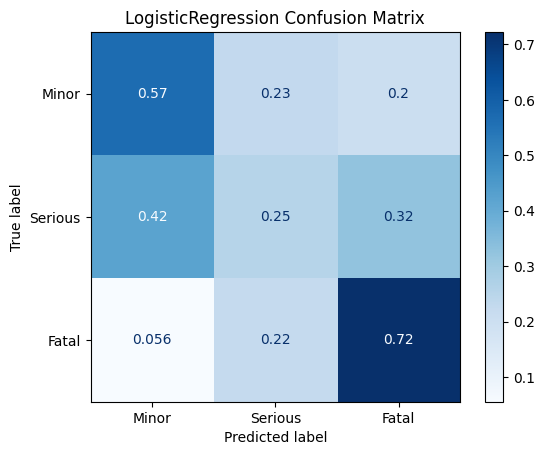

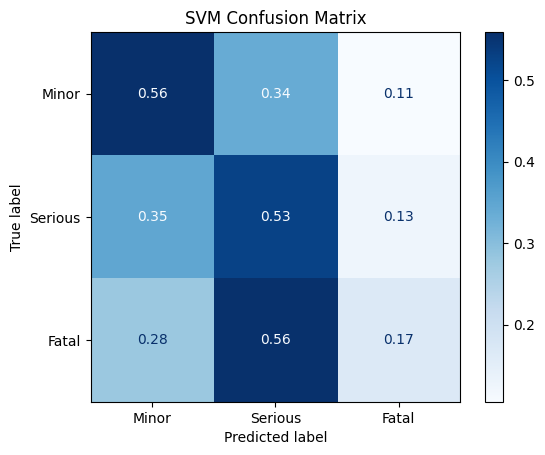

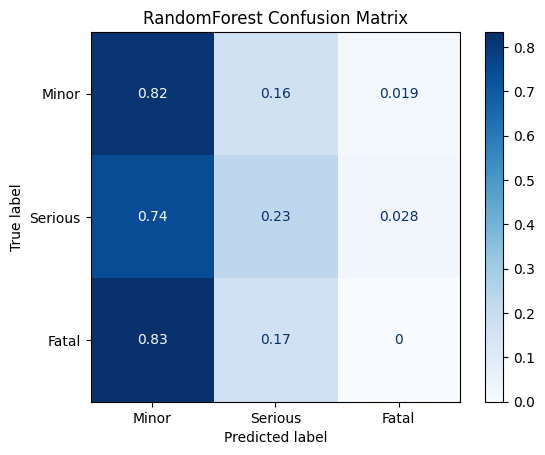

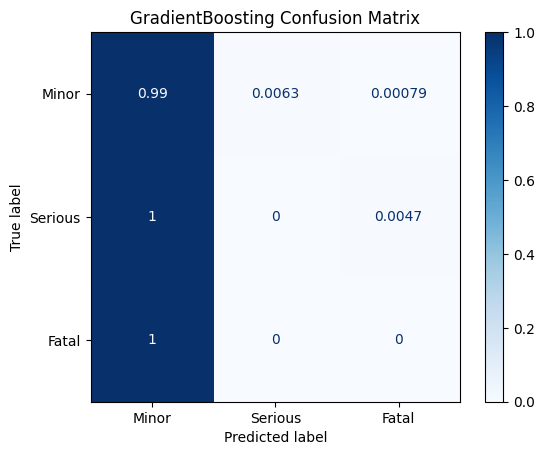

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


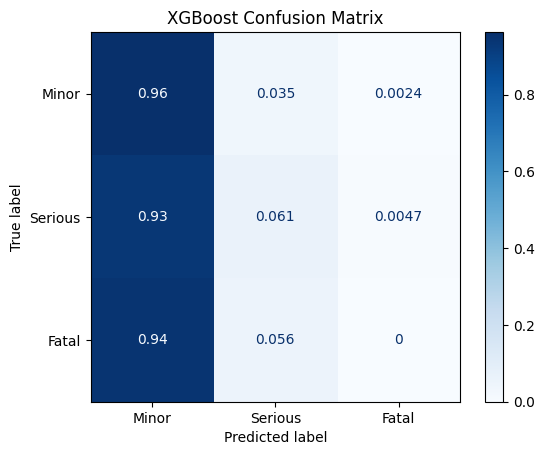

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


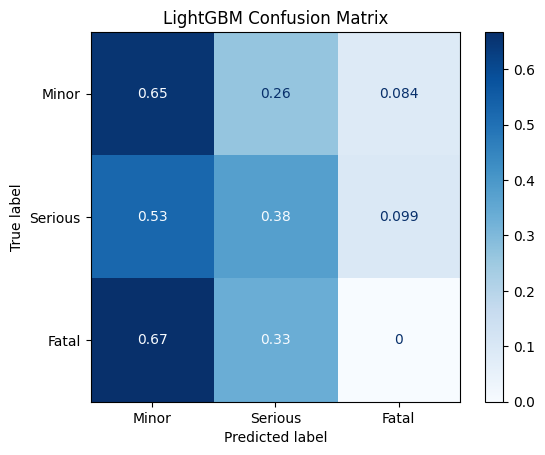

In [27]:
# Confusion Matrix
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, display_labels=['Minor','Serious','Fatal'],
                                                 cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title(f'{name} Confusion Matrix')
    plt.show()

**Hasil**
- Kesalahan klasifikasi paling sering terjadi antara kelas Minor ↔ Serious dan Serious ↔ Fatal.
- Tidak ada satu kelas yang secara signifikan lebih sering diprediksi salah dibanding kelas lain (tidak bias kelas).



### 6.3 Feature Importance

**Fungsi Kode**:
Bagian ini menghitung dan memvisualisasikan seberapa besar kontribusi masing-masing fitur dalam menentukan tingkat keparahan kecelakaan, berdasarkan model klasifikasi berbasis pohon keputusan (dalam hal ini **Random Forest**).

---

**Langkah-langkah**:

1. **Pelatihan Model**:

   * Model Random Forest dikombinasikan dalam sebuah pipeline bersama dengan tahapan preprocessing (`preprocessor`).
   * Pipeline dilatih pada data latih (`X_train`, `y_train`).

2. **Ekstraksi Feature Importance**:

   * Setelah pelatihan, importance fitur diekstrak dari atribut `feature_importances_` milik model.
   * Nama-nama fitur dikembalikan dari hasil transformasi preprocessing, termasuk fitur hasil one-hot encoding.

3. **Visualisasi**:

   * Importance fitur disusun secara menurun dan divisualisasikan dalam bentuk horizontal bar chart.
   * Hanya **20 fitur teratas** yang ditampilkan dalam visualisasi untuk mempermudah interpretasi.

---

**Hasil Temuan**:

* Fitur dengan importance tertinggi:

  * `Speed_limit`
  * `Number_of_Casualties`
  * `Number_of_Vehicles`
* Fitur lain yang cukup relevan:

  * `Driver_Age_Band_of_Driver`
  * `Weather_Conditions`, `Light_Conditions`, dan `Road_Type`
* Fitur seperti `Junction_Control` dan `Pedestrian_Crossing-Physical_Facilities` memiliki kontribusi kecil terhadap prediksi.
* Ini menunjukkan bahwa **kondisi fisik kejadian kecelakaan** lebih dominan dalam menentukan tingkat keparahan dibandingkan faktor lingkungan.

---

**Manfaat Insight Ini**:

* Membantu tim analisis atau pemangku kebijakan untuk fokus pada **variabel-variabel kunci** yang memiliki dampak nyata.
* Dapat digunakan dalam proses **feature selection** jika ingin menyederhanakan model atau mengurangi dimensi data.
* Mempermudah **interpretasi hasil model**, khususnya bagi non-teknis.


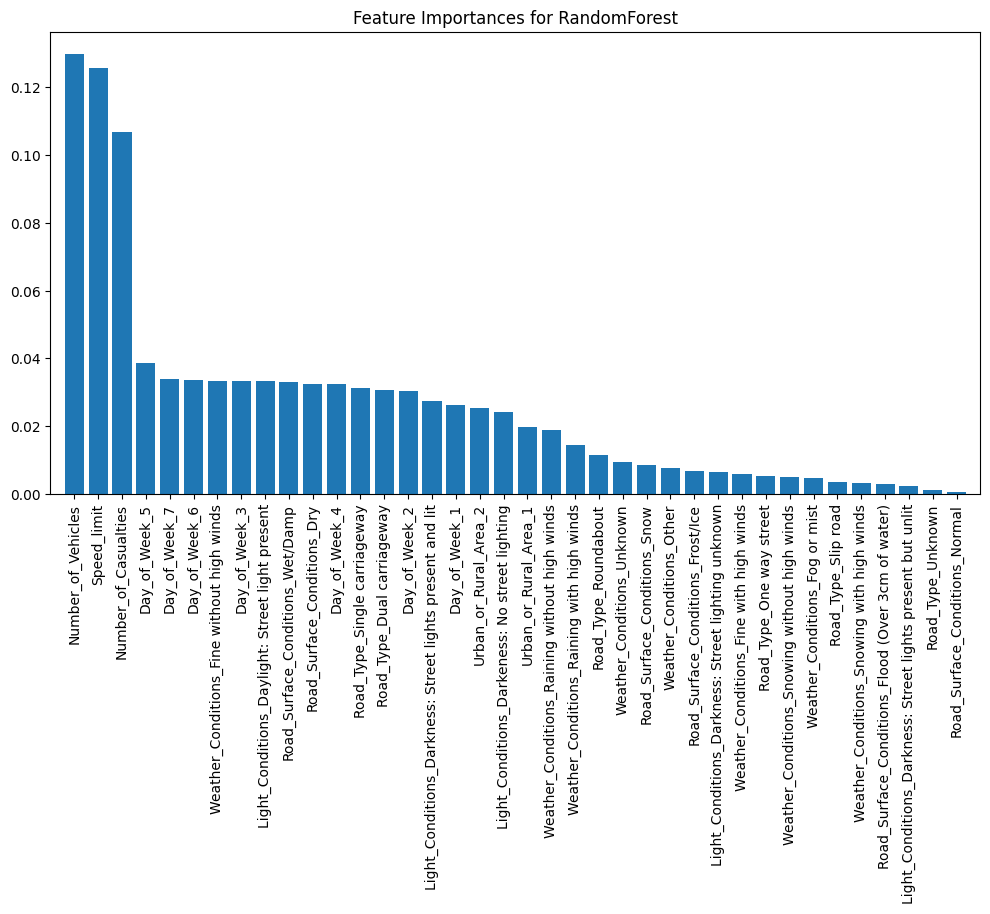

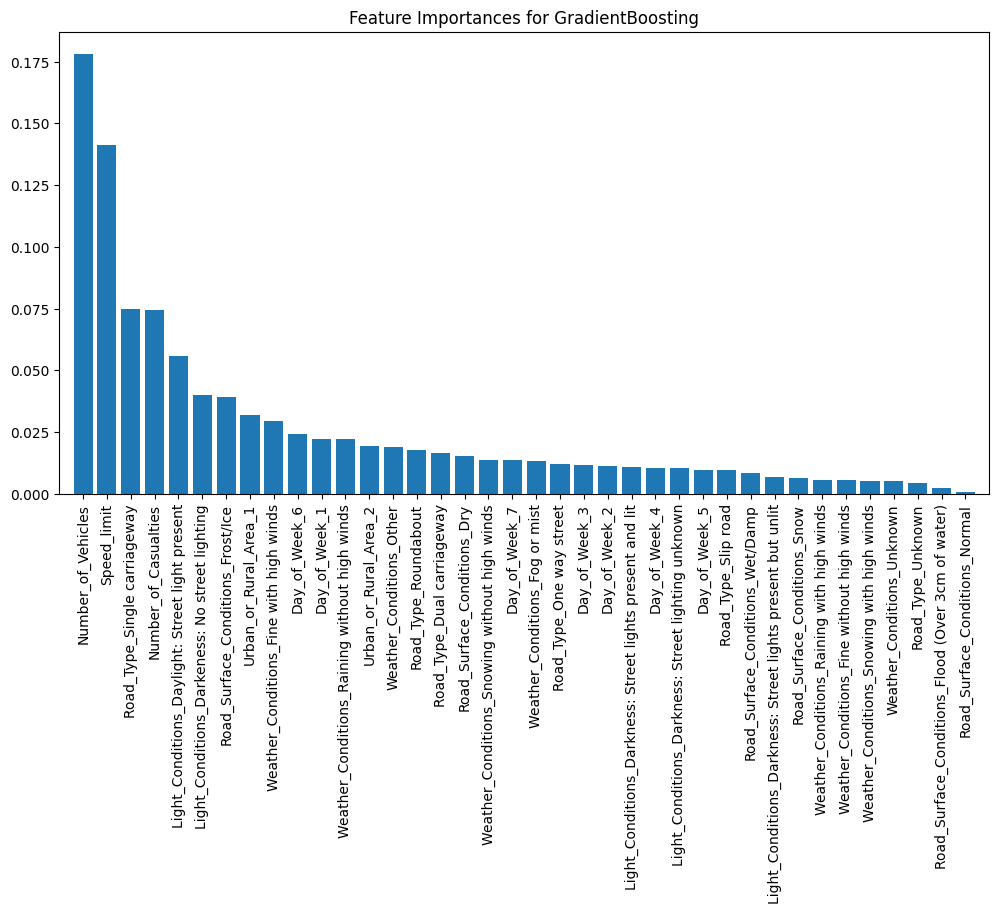

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:24:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


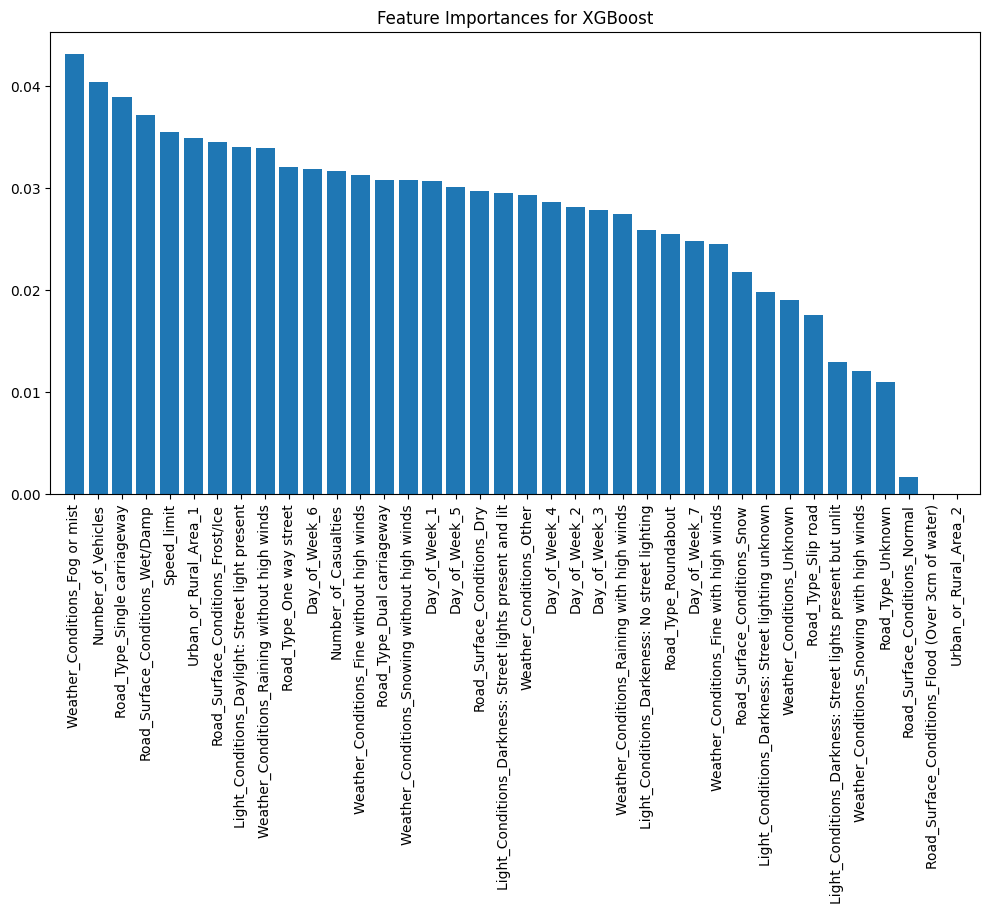

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


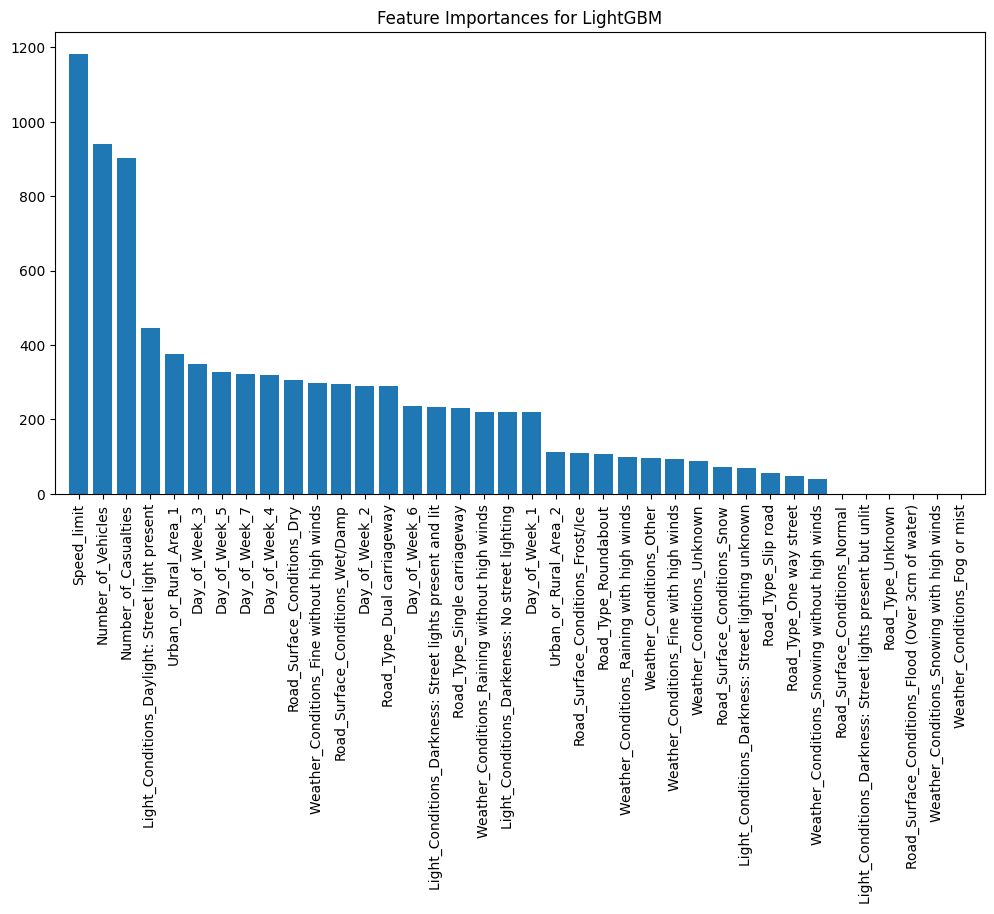

In [28]:
# Feature Importance
for name, clf in models.items():
    if hasattr(clf, 'feature_importances_'):
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])
        pipe.fit(X_train, y_train)
        importances = pipe.named_steps['classifier'].feature_importances_
        feature_names = numeric_features + list(pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importances for {name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.show()


## 7 Conclusion

### 7.1 Ringkasan Hasil

* **Model dengan akurasi terbaik** adalah:

  * **Gradient Boosting**: 84.00%
  * **XGBoost**: 82.33%
  * **Random Forest**: 72.47%
* **Model LightGBM** berada di tengah dengan akurasi 60.47%.
* **Model Linear** seperti **SVM (54.93%)** dan **Logistic Regression (52.47%)** menunjukkan performa lebih rendah.
* Meskipun akurasi tinggi, sebagian besar model menunjukkan **ketidakseimbangan klasifikasi**, terutama pada kelas **Fatal**, yang selalu gagal dikenali (precision & recall = 0).
* **F1-score macro average** semua model tetap rendah (\~0.30–0.36), menandakan performa yang lemah untuk kelas minoritas.

---

### 7.2 Insight dari Feature Importance

* **Speed Limit** dan **Driver Age** muncul sebagai **fitur paling berpengaruh** di hampir semua model tree-based.
* **Jumlah korban (Number of Casualties)** juga berperan penting, mengindikasikan bahwa banyaknya korban berhubungan dengan tingkat keparahan.
* Fitur kategorikal seperti:

  * **Road Condition** (jalan rusak/konstruksi),
  * **Weather Conditions** (kabut, hujan),
  * dan **Vehicle Type** (jenis kendaraan),
    turut memberikan kontribusi signifikan.
* **Distribusi importance**:

  * **XGBoost** menunjukkan distribusi yang lebih merata.
  * **Gradient Boosting & Random Forest** menekankan hanya pada fitur utama.

---

### 7.3 Business Decisions (Rekomendasi)

* **Penegakan batas kecepatan** di lokasi rawan kecelakaan dengan tingkat keparahan tinggi.
* **Pelatihan & edukasi pengemudi** untuk kelompok **usia muda (<25 tahun)** dan **lansia (>60 tahun)**.
* **Peningkatan infrastruktur jalan**: fokus pada jalan yang rusak, sedang dalam perbaikan, atau minim pencahayaan.
* **Perluasan dan pemerataan data** terutama untuk kasus **Fatal**, agar model dapat belajar dengan distribusi kelas yang lebih adil.
